In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

# Load Dataset

In [2]:
from typing import Sequence

from flax import linen as nn
import jax
import jax.numpy as jnp
import jax.random as jr
import optax

from bong.src.dataloaders import generate_stationary_experiment

dataset_fn, kwargs = generate_stationary_experiment(10_000, 100).values()
dataset = dataset_fn()

X_tr, y_tr = dataset['train']
X_val, y_val = dataset['val']
X_te, y_te = dataset['test']

/home/peter0414/bong/.bong_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-22 17:35:10.626065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from flax import linen as nn
import optax
from typing import Sequence
from jax.flatten_util import ravel_pytree
import jax.random as jr

class MLP(nn.Module):
    features: Sequence[int]
    activation: nn.Module = nn.relu
    use_bias: bool = True

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = self.activation(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1], use_bias=self.use_bias)(x)
        return x

In [4]:
model = MLP(features = [50, 50, 10,], use_bias=True)
params = model.init(jr.PRNGKey(0), X_tr[0])
flat_params, unflatten_fn = ravel_pytree(params)
apply_fn = lambda w, x: model.apply(unflatten_fn(w), jnp.atleast_1d(x))

# 1. BONG

In [5]:
from functools import partial

import matplotlib.pyplot as plt
import optax
import optuna

from bong.src import bong
from bong.util import run_rebayes_algorithm, tune_init_cov

log_likelihood = lambda mean, cov, y: -optax.softmax_cross_entropy(mean, y)
em_function = apply_fn
em_linpi_function = lambda w, x: jax.nn.softmax(apply_fn(w, x))
def ec_function(w, x):
    ps = em_linpi_function(w, x)
    cov = jnp.diag(ps) - jnp.outer(ps, ps) + 1e-5 * jnp.eye(len(ps))
    return jnp.atleast_2d(cov)
def callback_fn(key, alg, state, x, y, X_curr, y_curr, num_samples=10):
    states = alg.sample(key, state, num_samples)
    y_pred_logits = jnp.mean(jax.vmap(
        jax.vmap(em_function, (None, 0)), (0, None)
    )(states, X_curr), axis=0)
    y_preds = jnp.argmax(y_pred_logits, axis=-1)
    accuracy = jnp.mean(y_preds == y_curr)
    loglikhood = jnp.mean(-optax.softmax_cross_entropy_with_integer_labels(
        y_pred_logits, y_curr
    ))
    return accuracy, loglikhood
def loss_fn(key, alg, state, num_samples=10):
    states = alg.sample(key, state, num_samples)
    y_pred_logits = jnp.mean(jax.vmap(
        jax.vmap(em_function, (None, 0)), (0, None)
    )(states, X_val), axis=0)
    negloglikhood = optax.softmax_cross_entropy_with_integer_labels(
        y_pred_logits, y_val
    )
    return jnp.mean(negloglikhood)

## 1.1. DG-BONG

In [6]:
key = jr.PRNGKey(0)

# Tune Hyperparameter
init_kwargs = {
    "init_mean": flat_params,
    "log_likelihood": log_likelihood,
    "emission_mean_function": em_function,
    "emission_cov_function": ec_function,
}
best_param = tune_init_cov(key, bong.dg_bong, X_tr, y_tr, loss_fn, **init_kwargs)

[I 2024-04-22 17:35:33,770] A new study created in memory with name: no-name-a56efeb4-4c07-4c19-9f94-d49bd8ddb085


In [ ]:
# Evaluate on test set
init_cov = jnp.exp(best_param["log_init_cov"]).item()

# Initialize DG-BONG
dg_bong = bong.dg_bong(
    **init_kwargs,
    init_cov=init_cov,
)

# Run DG-BONG
dg_state, (dg_acc, dg_ll) = run_rebayes_algorithm(
    key,
    dg_bong,
    X_tr,
    y_tr,
    transform=partial(callback_fn, X_curr=X_te, y_curr=y_te),
)

## 1.2. DG-L-BONG (VDEKF)

In [ ]:
key = jr.PRNGKey(0)

# Tune Hyperparameter
init_linpi_kwargs = {
    "init_mean": flat_params,
    "log_likelihood": log_likelihood,
    "emission_mean_function": em_linpi_function,
    "emission_cov_function": ec_function,
    "linplugin": True
}
dgl_best_param = tune_init_cov(key, bong.dg_bong, X_tr, y_tr, loss_fn, **init_linpi_kwargs)

[I 2024-04-22 17:13:52,273] A new study created in memory with name: no-name-b9804e0c-6f8e-4cd8-ab9b-fb209bf26a74
[W 2024-04-22 17:14:56,987] Trial 0 failed with parameters: {'log_init_cov': -0.26822978745063253} because of the following error: The value nan is not acceptable.
[W 2024-04-22 17:14:56,990] Trial 0 failed with value Array(nan, dtype=float32).
[I 2024-04-22 17:15:06,280] Trial 1 finished with value: 1.6825884580612183 and parameters: {'log_init_cov': -8.971255755838163}. Best is trial 1 with value: 1.6825884580612183.
[I 2024-04-22 17:15:15,619] Trial 2 finished with value: 0.6780391335487366 and parameters: {'log_init_cov': -6.515743649001564}. Best is trial 2 with value: 0.6780391335487366.
[I 2024-04-22 17:15:24,939] Trial 3 finished with value: 0.6166648864746094 and parameters: {'log_init_cov': -5.808674651301869}. Best is trial 3 with value: 0.6166648864746094.
[I 2024-04-22 17:15:34,370] Trial 4 finished with value: 0.6864421963691711 and parameters: {'log_init_cov'

In [ ]:
# Evaluate on test set
init_cov = jnp.exp(dgl_best_param["log_init_cov"]).item()

# Initialize DG-L-BONG
dgl_bong = bong.dg_bong(
    **init_linpi_kwargs,
    init_cov=init_cov,
)

# Run DG-L-BONG
dgl_state, (dgl_acc, dgl_ll) = run_rebayes_algorithm(
    key,
    dgl_bong,
    X_tr,
    y_tr,
    transform=partial(callback_fn, X_curr=X_te, y_curr=y_te),
)

## 1.3. DG-Reparam-BONG

In [ ]:
key = jr.PRNGKey(0)

# Tune Hyperparameter
init_kwargs = {
    "init_mean": flat_params,
    "log_likelihood": log_likelihood,
    "emission_mean_function": em_function,
    "emission_cov_function": ec_function,
}
dg_rp_best_param = tune_init_cov(key, bong.dg_reparam_bong, X_tr, y_tr, loss_fn, **init_kwargs)

[I 2024-04-22 17:16:27,355] A new study created in memory with name: no-name-11c0c1b5-1704-48a6-aa62-1e207d3a5f3a
[I 2024-04-22 17:17:34,646] Trial 0 finished with value: 1.0293898582458496 and parameters: {'log_init_cov': -7.911024090033215}. Best is trial 0 with value: 1.0293898582458496.
[I 2024-04-22 17:18:30,740] Trial 1 finished with value: 0.6539095044136047 and parameters: {'log_init_cov': -6.219519371687793}. Best is trial 1 with value: 0.6539095044136047.
[I 2024-04-22 17:19:26,765] Trial 2 finished with value: 0.9459518790245056 and parameters: {'log_init_cov': -7.718326873253365}. Best is trial 1 with value: 0.6539095044136047.
[I 2024-04-22 17:20:23,170] Trial 3 finished with value: 0.8670571446418762 and parameters: {'log_init_cov': -7.485004473763696}. Best is trial 1 with value: 0.6539095044136047.
[I 2024-04-22 17:21:19,171] Trial 4 finished with value: 0.8633274435997009 and parameters: {'log_init_cov': -7.4700274584790005}. Best is trial 1 with value: 0.6539095044136

In [ ]:
# Evaluate on test set
init_cov = jnp.exp(dg_rp_best_param["log_init_cov"]).item()

# Initialize DG-Reparam-BONG
dg_reparam_bong = bong.dg_reparam_bong(
    **init_kwargs,
    init_cov=init_cov,
)

# Run DG-Reparam-BONG
dg_reparam_state, (dg_reparam_acc, dg_reparam_ll) = run_rebayes_algorithm(
    key,
    dg_reparam_bong,
    X_tr,
    y_tr,
    transform=partial(callback_fn, X_curr=X_te, y_curr=y_te),
)

## 1.4. DG-Reparam-L-BONG

In [ ]:
key = jr.PRNGKey(0)

# Tune Hyperparameter
init_linpi_kwargs = {
    "init_mean": flat_params,
    "log_likelihood": log_likelihood,
    "emission_mean_function": em_linpi_function,
    "emission_cov_function": ec_function,
    "linplugin": True
}
dgl_rp_best_param = tune_init_cov(key, bong.dg_reparam_bong, X_tr, y_tr, loss_fn, **init_linpi_kwargs)

[I 2024-04-22 17:26:05,945] A new study created in memory with name: no-name-e15c917f-94f4-43ba-8c12-ff5d8ff7fcda
[I 2024-04-22 17:27:10,734] Trial 0 finished with value: 1.1338164806365967 and parameters: {'log_init_cov': -2.4592423947998707}. Best is trial 0 with value: 1.1338164806365967.
[I 2024-04-22 17:27:17,257] Trial 1 finished with value: 0.5798132419586182 and parameters: {'log_init_cov': -5.482712312914806}. Best is trial 1 with value: 0.5798132419586182.
[W 2024-04-22 17:27:23,555] Trial 2 failed with parameters: {'log_init_cov': -2.2658055771956134} because of the following error: The value nan is not acceptable.
[W 2024-04-22 17:27:23,557] Trial 2 failed with value Array(nan, dtype=float32).
[I 2024-04-22 17:27:30,043] Trial 3 finished with value: 0.7565605640411377 and parameters: {'log_init_cov': -7.031705225142462}. Best is trial 1 with value: 0.5798132419586182.
[I 2024-04-22 17:27:36,293] Trial 4 finished with value: 998.7427978515625 and parameters: {'log_init_cov':

In [ ]:
# Evaluate on test set
init_cov = jnp.exp(dgl_rp_best_param["log_init_cov"]).item()

# Initialize DG-Reparam-L-BONG
dgl_reparam_bong = bong.dg_reparam_bong(
    **init_linpi_kwargs,
    init_cov=init_cov,
)

# Run DG-Reparam-L-BONG
dgl_reparam_state, (dgl_reparam_acc, dgl_reparam_ll) = run_rebayes_algorithm(
    key,
    dgl_reparam_bong,
    X_tr,
    y_tr,
    transform=partial(callback_fn, X_curr=X_te, y_curr=y_te),
)

In [ ]:
# Smoothed Accuracies
def convolve_smooth(data, width=50):
    cumsum_vec = jnp.cumsum(jnp.insert(data, 0, 0))
    smoothed_vec = (cumsum_vec[width:] - cumsum_vec[:-width]) / width
    return smoothed_vec

dg_acc_s = convolve_smooth(dg_acc)
dgl_acc_s = convolve_smooth(dgl_acc)
dg_reparam_acc_s = convolve_smooth(dg_reparam_acc)
dgl_reparam_acc_s = convolve_smooth(dgl_reparam_acc)

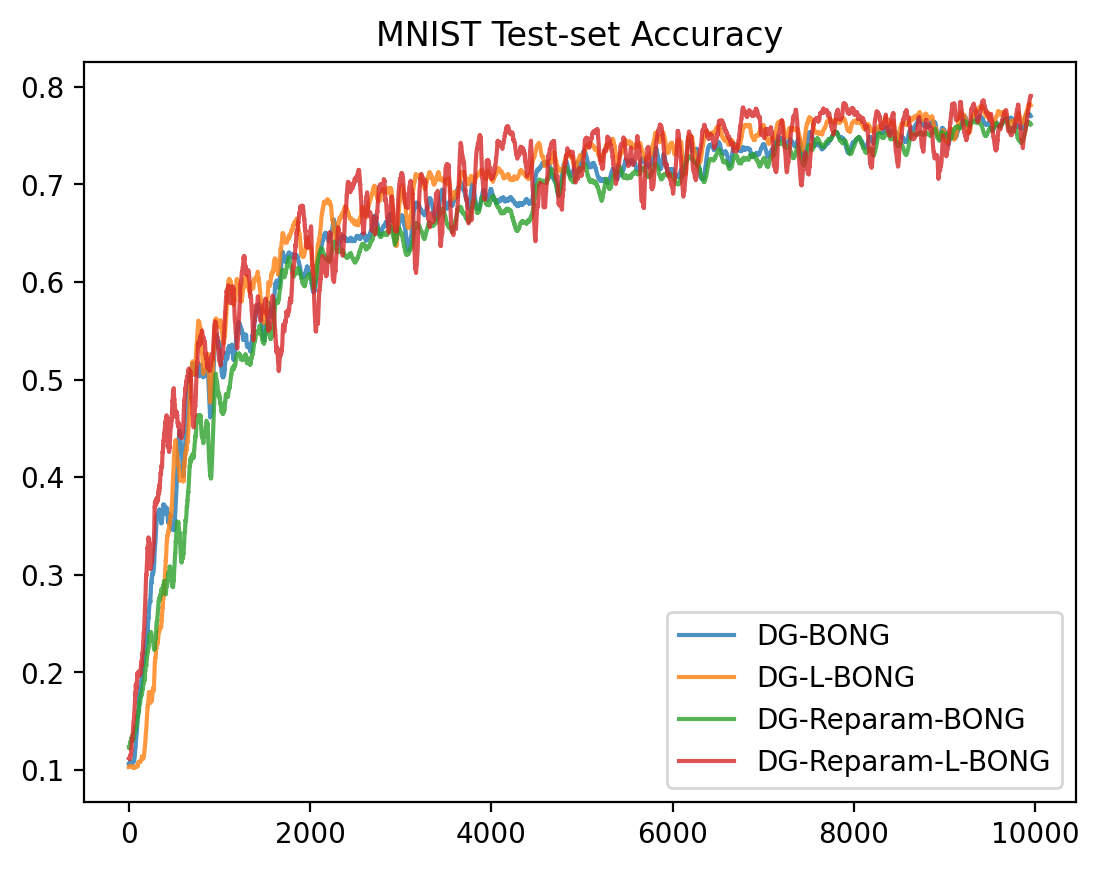

In [21]:
# Plot Accuracy
fig, ax = plt.subplots()
ax.plot(dg_acc_s, label="DG-BONG", alpha=0.8);
ax.plot(dgl_acc_s, label="DG-L-BONG", alpha=0.8);
ax.plot(dg_reparam_acc_s, label="DG-Reparam-BONG", alpha=0.8)
ax.plot(dgl_reparam_acc_s, label="DG-Reparam-L-BONG", alpha=0.8)
ax.legend()
ax.set_title("MNIST Test-set Accuracy");

In [ ]:
# Smoothed Log-Likelihoods
dg_ll_s = convolve_smooth(dg_ll)
dgl_ll_s = convolve_smooth(dgl_ll)
dg_reparam_ll_s = convolve_smooth(dg_reparam_ll)
dgl_reparam_ll_s = convolve_smooth(dgl_reparam_ll)

# Plot Log-Likelihood
fig, ax = plt.subplots()
ax.plot(dg_ll_s, label="DG-BONG", alpha=0.8);
ax.plot(dgl_ll_s, label="DG-L-BONG", alpha=0.8);
ax.plot(dg_reparam_ll_s, label="DG-Reparam-BONG", alpha=0.8)
ax.plot(dgl_reparam_ll_s, label="DG-Reparam-L-BONG", alpha=0.8)
ax.legend()
ax.set_title("MNIST Test-set Log-Likelihood");